In [70]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting Sensory data

- We are using data from Garmin watch. 
- For this assignment running activities were observed, specifically tempo and recovery runs. 
- 4 runs were extracted: 12km tempo, 10km tempo, 10km recovery, 8km recovery. In total, ~4h of data. Each run activity is labeled according to its type and distance.
- **Features:** 
    - Time
    - Distance
    - Altitude
    - Cadence
    - HeartRate
    - Speed
- **Engineered features (TBD):**
    - Pace (Time/Distance)
    - Elevation Gain (to be calculated)
    - Cadence per minute (In current dataset cadence metric is really akward and hardly understandable. Usually, cadence measures frequency of steps (for both feet) per minute. Moreover, in this dataset cadence corresponds to frequency of steps only for one foot, so it should be multiplied by 2)

In [71]:
def parse_tcx(tcx_file):
    tree = ET.parse(tcx_file)
    root = tree.getroot()

    data = []
    
    for activity in root.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Activities'):
        for lap in activity.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Lap'):
            for track in lap.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Track'):
                for trackpoint in track.findall('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Trackpoint'):
                    # Extract time, distance, and heart rate data
                    time_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time')
                    distance_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters')
                    heart_rate_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}HeartRateBpm/{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Value')
                    speed_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Speed')
                    run_cadence_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Extensions/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX/{http://www.garmin.com/xmlschemas/ActivityExtension/v2}RunCadence')
                    altitude_element = trackpoint.find('{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}AltitudeMeters')
                    
                    if time_element is not None and distance_element is not None and heart_rate_element is not None and run_cadence_element is not None and speed_element is not None:
                        data.append({
                            'Time': time_element.text,
                            'Distance': float(distance_element.text),
                            'Altitude': float(altitude_element.text),
                            'HeartRate': int(heart_rate_element.text),
                            'Speed': float(speed_element.text),
                            'Cadence': int(run_cadence_element.text)
                        })

    return data

def heart_rate_zone(heart_rate):
    # Define your own heart rate zones here
    if heart_rate <= 141:
        return 'Zone 1'
    elif heart_rate >= 142 and heart_rate <= 157:
        return 'Zone 2'
    elif heart_rate >= 158 and heart_rate <= 167:
        return 'Zone 3'
    elif heart_rate >= 168 and heart_rate <= 174:
        return 'Zone 4'
    elif heart_rate > 174:
        return 'Zone 5'


# # Calculate pace (time per km) - note this is a simple calculation and may not be accurate
# def calculate_pace(df):
#     df['Time'] = pd.to_datetime(df['Time'])
#     timeDiff = df['Time'].diff()
#     distanceDiff = df['Distance'].diff()
#     df['Pace'] = timeDiff.dt.total_seconds() / distanceDiff
    

#Activity labels. Currently not used
labels = ['recovery','tempo']

In [72]:
tcx_files = ['10km_tempo.tcx', '12km_tempo.tcx', '8km_recovery.tcx', '10km_recovery.tcx']

dataframes = []

for file in tcx_files:
    # Parse the TCX file to a DataFrame
    data = parse_tcx('data/'+ file)
    df = pd.DataFrame(data)
    #calculate_pace(df)
    df['HeartRateZone'] = df['HeartRate'].apply(heart_rate_zone)
    df['Run'] = os.path.splitext(file)[0]  # extracts "10km_tempo", "12km_tempo", etc. from file names

    # Append the DataFrame to the list
    dataframes.append(df)
# Concatenate all dataframes
all_runs_df = pd.concat(dataframes, ignore_index=True)
all_runs_df.to_csv('running_data.csv')

## Initial exploratory Data Analysis

In [73]:
data = pd.read_csv('running_data.csv', delimiter = ',')

print(data)

       Unnamed: 0                      Time      Distance    Altitude  \
0               0  2022-07-29T05:21:40.000Z      1.200000  325.600006   
1               1  2022-07-29T05:21:41.000Z      3.670000  325.600006   
2               2  2022-07-29T05:21:42.000Z      6.070000  325.600006   
3               3  2022-07-29T05:21:43.000Z      7.870000  325.600006   
4               4  2022-07-29T05:21:44.000Z     10.080000  325.600006   
...           ...                       ...           ...         ...   
15113       15113  2022-09-06T06:00:59.000Z  10003.740234   -1.000000   
15114       15114  2022-09-06T06:00:59.000Z  10003.740234   -1.000000   
15115       15115  2022-09-06T06:01:00.000Z  10006.309570   -0.800000   
15116       15116  2022-09-06T06:01:01.000Z  10010.650391   -0.800000   
15117       15117  2022-09-06T06:01:02.000Z  10010.650391   -0.800000   

       HeartRate  Speed  Cadence HeartRateZone            Run  
0             92  0.000       83        Zone 1     10km_tem

In [74]:
#fixing Cadence to be for both feet
data['Cadence'] = data['Cadence'] * 2

### Helper functions

In [75]:
def count_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing values per column:")
    for column, count in missing_values.iteritems():
        print(f"{column}: {count}")

def plot_column(df, column_name):
    # plt.plot(df[column_name])
    plt.scatter(df.index, df[column_name], marker='o', s=5)
    plt.xlabel('Index')
    plt.ylabel(column_name)
    plt.title(f'Plot of {column_name}')
    plt.show()

def plot_column_per_run(data, column_name):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    # Iterate over each run type and plot the feature in the corresponding subplot
    for i, run_type in enumerate(data['Run'].unique()):
        ax = axes[i // 2, i % 2]  # Get the appropriate subplot
        subset = data[data['Run'] == run_type]  # Filter the data for the specific run type
        
        # Plot the feature for the run type
        ax.plot(subset[column_name])
        ax.set_title(f'{column_name} {run_type}')  # Set the subplot title
        

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

### Analysis the for whole dataset

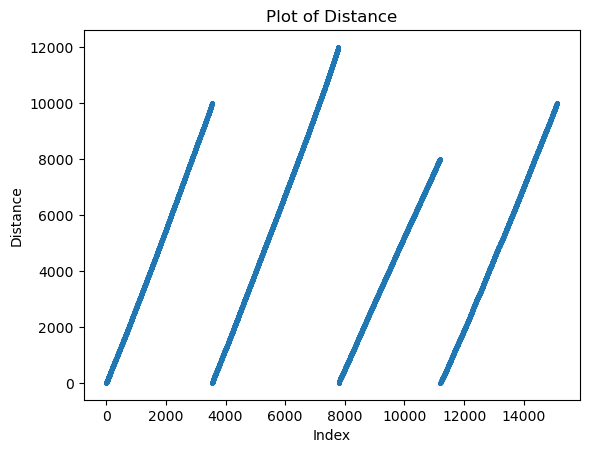

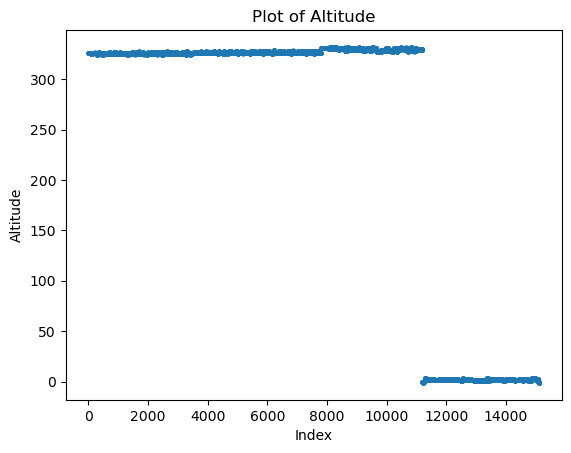

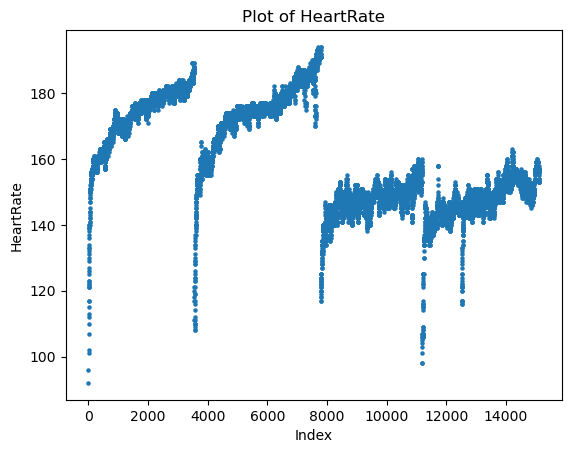

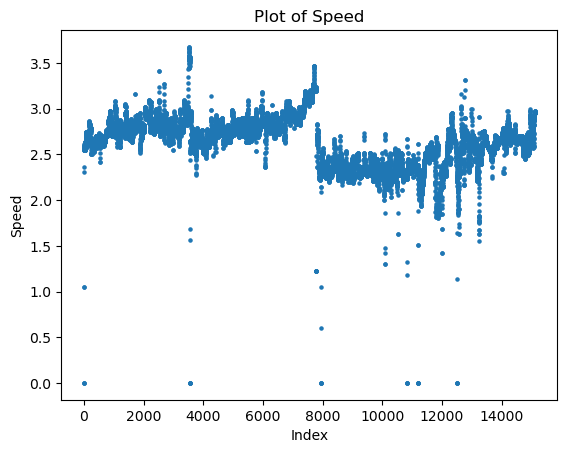

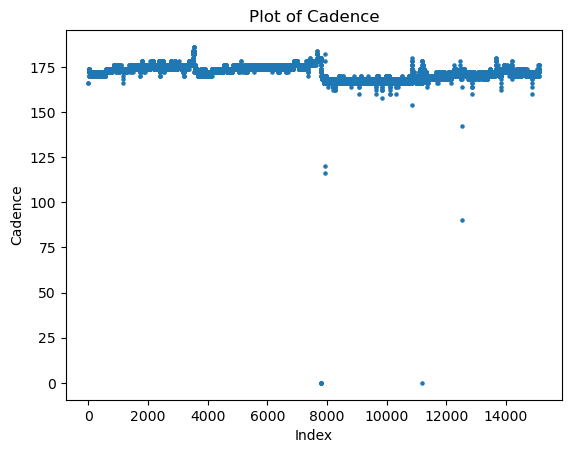

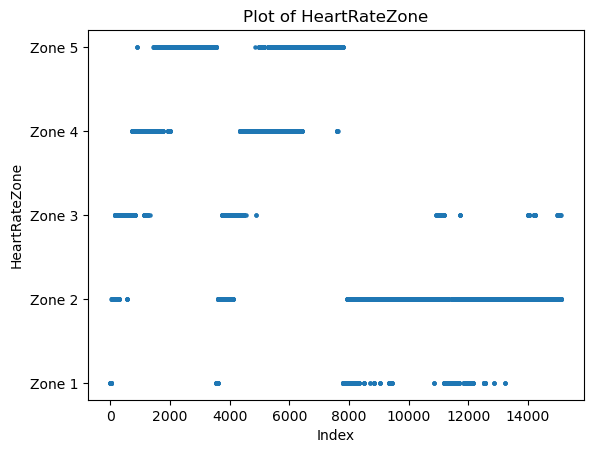

In [76]:
plot_column(data, 'Distance')
plot_column(data, 'Altitude')
plot_column(data, 'HeartRate')
plot_column(data, 'Speed')
plot_column(data, 'Cadence')
plot_column(data, 'HeartRateZone')


### Distribution of features per each run

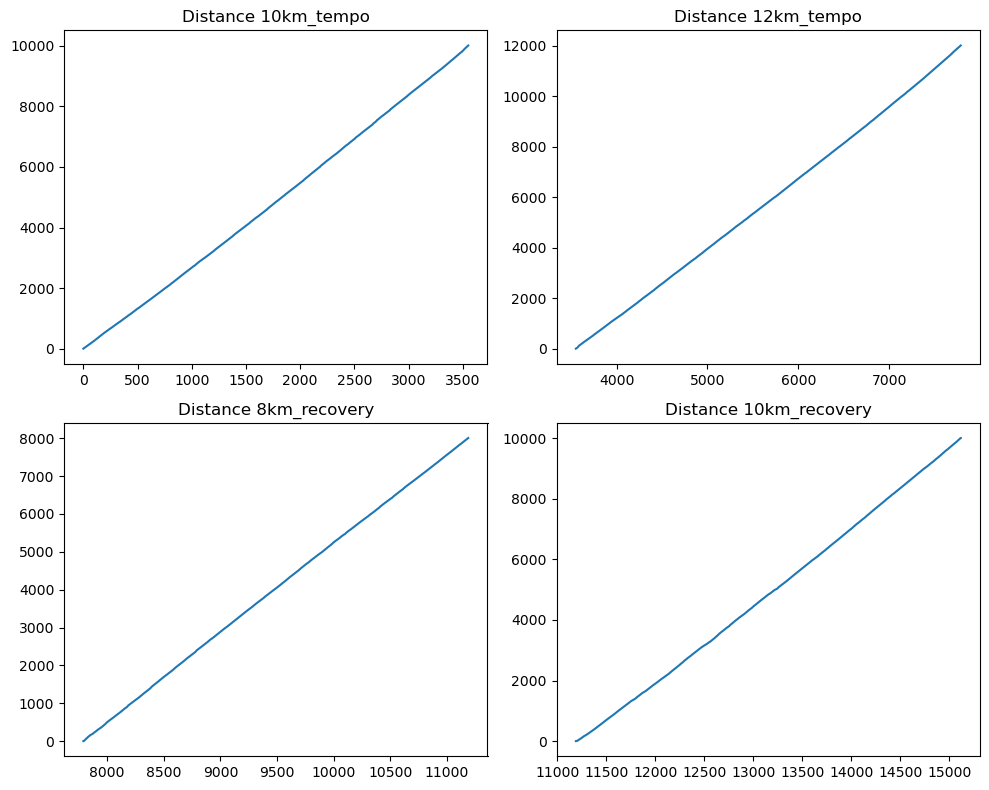

In [77]:
plot_column_per_run(data, 'Distance')

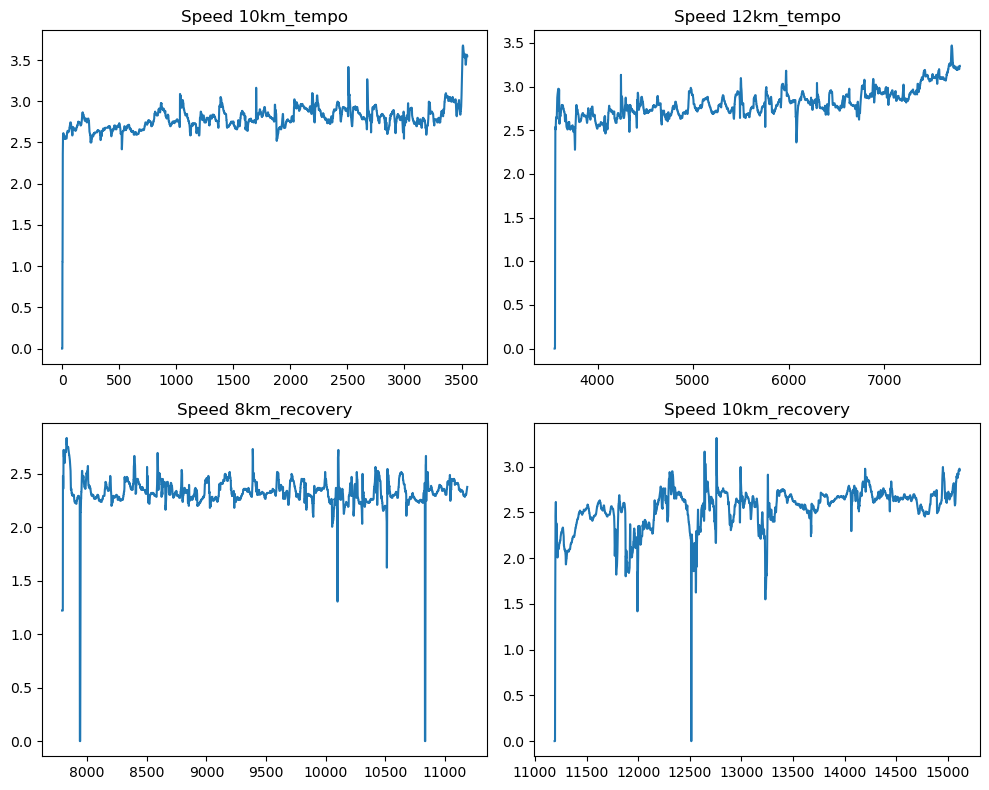

In [78]:
plot_column_per_run(data, 'Speed')

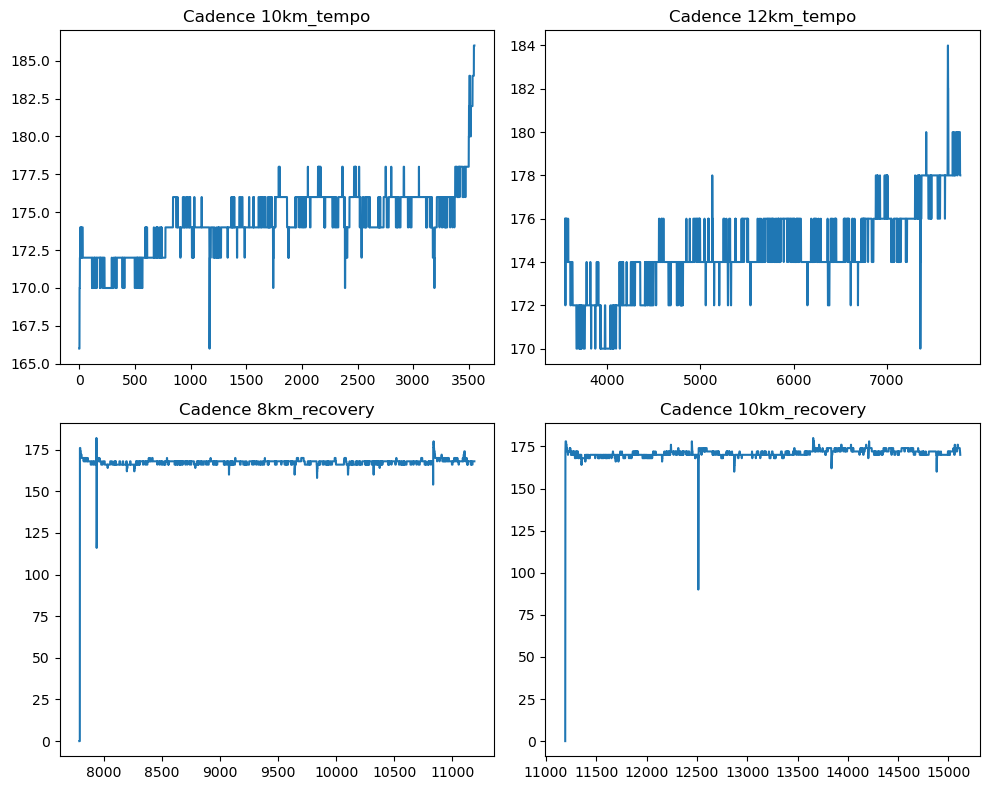

In [79]:
plot_column_per_run(data, 'Cadence')

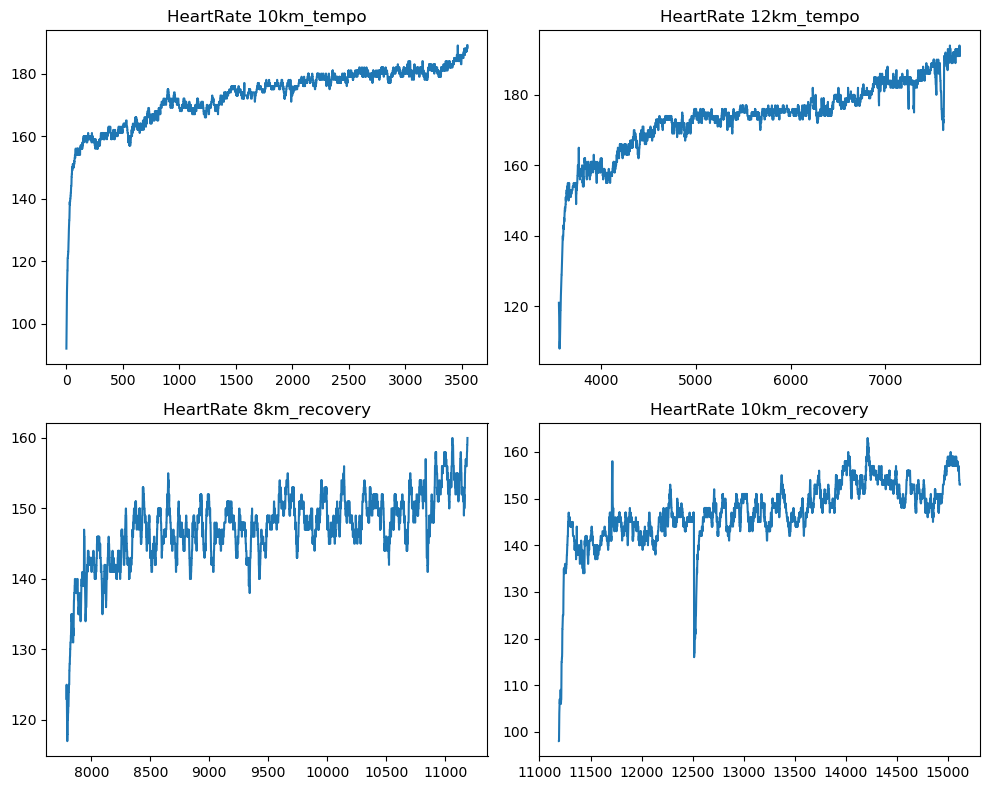

In [80]:
plot_column_per_run(data, 'HeartRate')

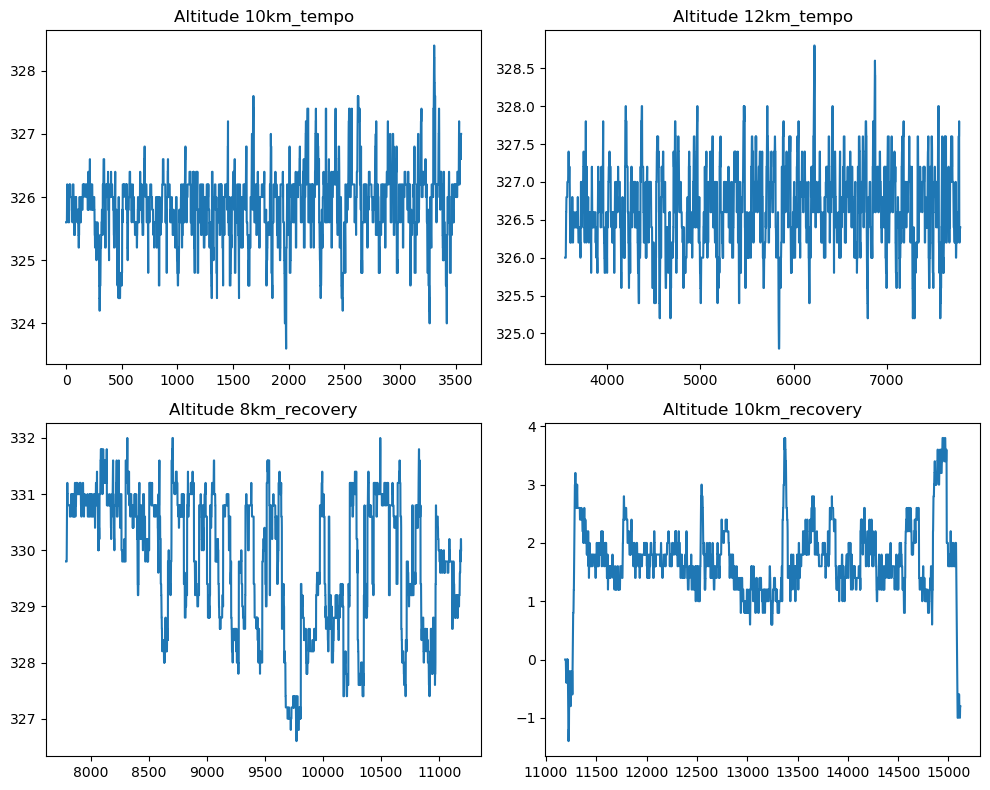

In [81]:
plot_column_per_run(data, 'Altitude')

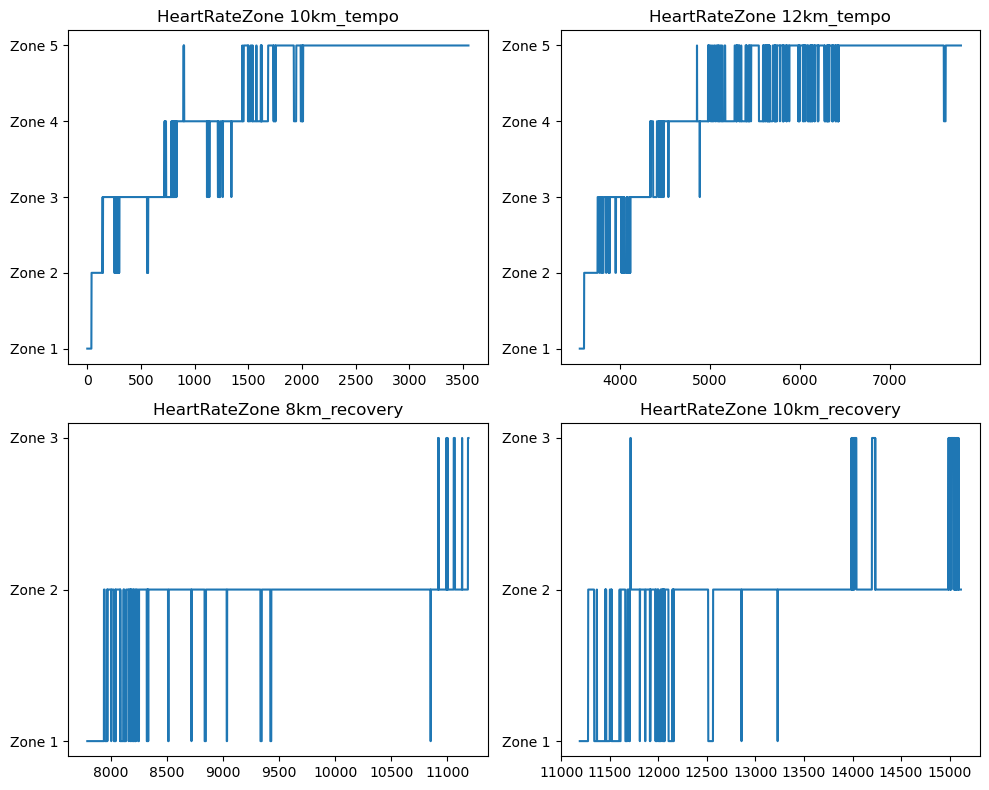

In [82]:
plot_column_per_run(data, 'HeartRateZone')

### Removing outliers

### Heart rate

In [83]:
data['HeartRate'] = data['HeartRate'].astype(float)

last_value = data['HeartRate'].iloc[0]
last_run = data['Run'].iloc[0]
for index, row in data.iterrows():
    current_value = row['HeartRate']
    current_run = row['Run']
    if(last_run == current_run) and ((current_value - last_value) > 7 or (last_value - current_value) > 7):
        # Remove the current value
        # df_D_clean.drop(index, inplace=True)
        data.at[index, 'HeartRate'] = np.nan
        #print('drop')
    else:
        last_value = current_value
        last_run = current_run


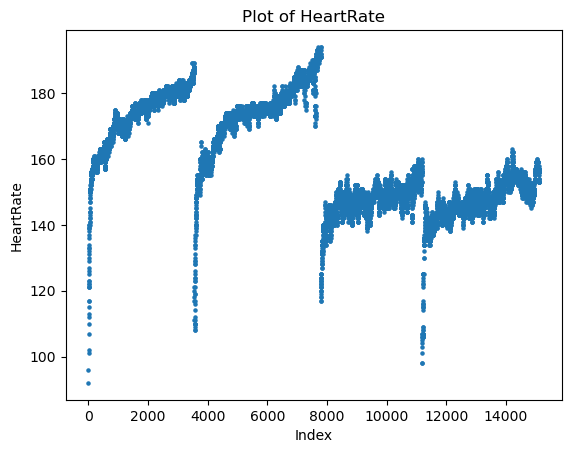

In [84]:
plot_column(data, 'HeartRate')

### Cadence

In [85]:
data['Cadence'] = data['Cadence'].astype(float)

for index, row in data.iterrows():
    current_value = row['Cadence']
    if(last_run == current_run) and current_value < 150: # trial and eror, not based on min or max possible. Hold back with removing to much because could be ciritical information
        data.at[index, 'Cadence'] = np.nan
    else:
        last_run = current_run

num_nan = data['Cadence'].isna().sum()
print(f"Number of NaN values in 'cadence': {num_nan}")

Number of NaN values in 'cadence': 10


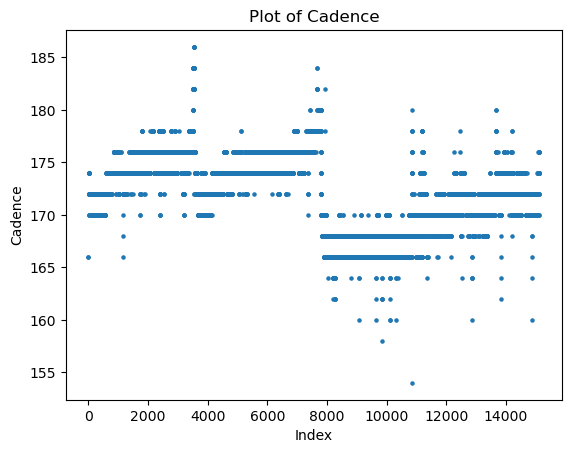

In [86]:
plot_column(data, 'Cadence')

### Speed

In [87]:
data['Speed'] = data['Speed'].astype(float)

last_value = data['Speed'].iloc[0]
last_run = data['Run'].iloc[0]
for index, row in data.iterrows():
    current_value = row['Speed']
    current_run = row['Run']
    if(last_run == current_run) and ((current_value - last_value) > 2 or (last_value - current_value) > 2):  # while jogging may have acceleration values around 1-2 m/s². choose the max to not remove citical values
        data.at[index, 'Speed'] = np.nan
    else:
        last_value = current_value
        last_run = current_run

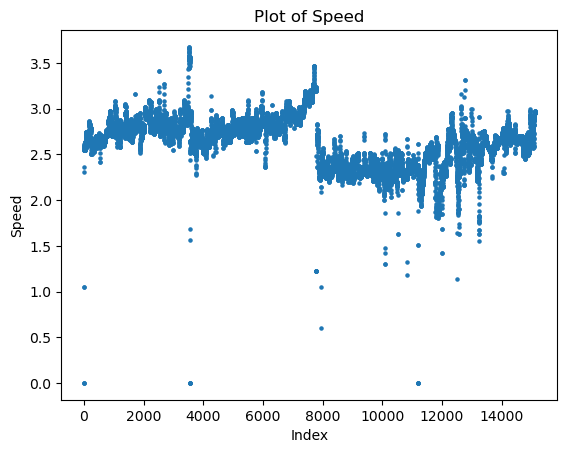

In [88]:
plot_column(data, 'Speed')

### Altitude

In [89]:
data['Altitude'] = data['Altitude'].astype(float)

last_value = data['Altitude'].iloc[0]
last_run = data['Run'].iloc[0]
for index, row in data.iterrows():
    current_value = row['Altitude']
    current_run = row['Run']
    if(last_run == current_run) and ((current_value - last_value) > 1 or (last_value - current_value) > 1): # was found to max change 0.55 within 1 sec. Does remove a lot but this could be explained by noise. Will be fixed with value imputation with neighbouring method
        data.at[index, 'Altitude'] = np.nan
    else:
        last_value = current_value
        last_run = current_run

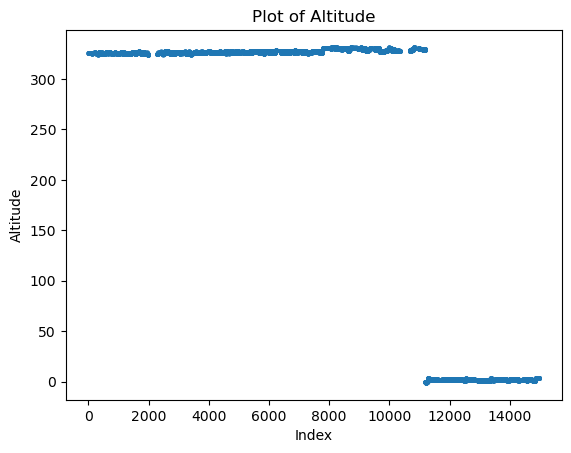

In [90]:
plot_column(data, 'Altitude')

In [91]:
count_missing_values(data)

Missing values per column:
Unnamed: 0: 0
Time: 0
Distance: 0
Altitude: 2757
HeartRate: 51
Speed: 12
Cadence: 10
HeartRateZone: 0
Run: 0


/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_48719/1562971855.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, count in missing_values.iteritems():


## Imputing missing values

### Heart Rate

In [92]:
data['HeartRate'] = data['HeartRate'].interpolate(method='polynomial', order=3)

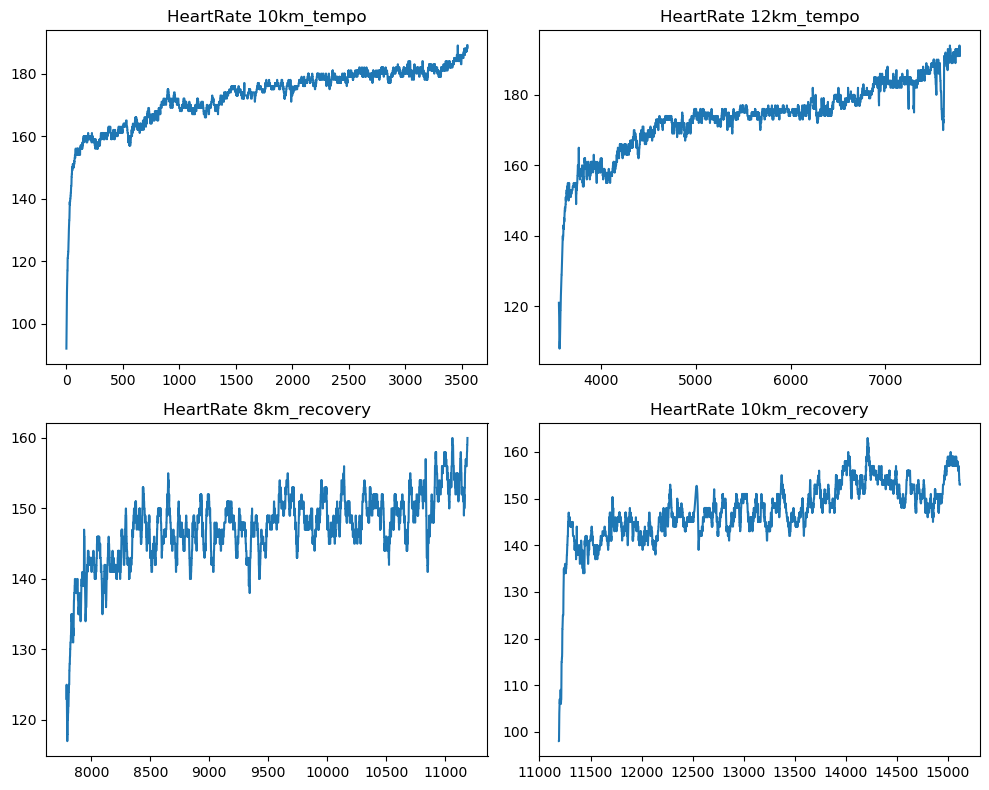

In [93]:
## Using interpolation
plot_column_per_run(data, 'HeartRate')

### Cadence

In [94]:
## Backward fill
# data['Cadence'] = df['Cadence'].fillna(method='bfill')
## Interpolation
data['Cadence'] = data['Cadence'].interpolate()


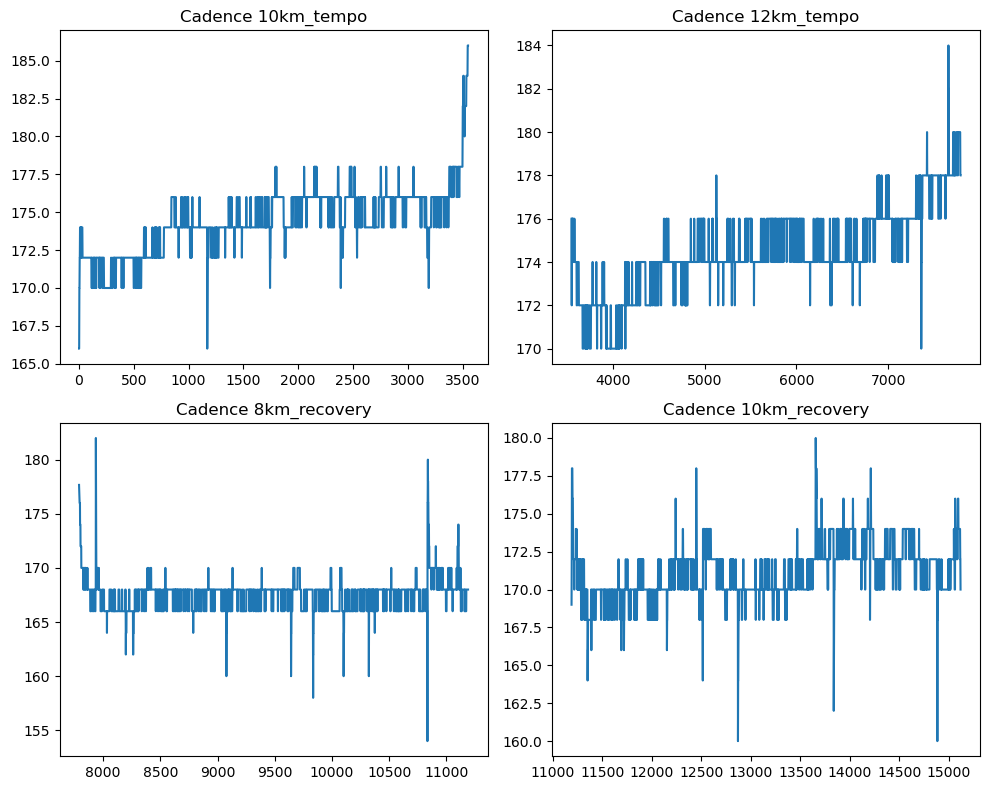

In [95]:
plot_column_per_run(data, 'Cadence')

### Speed

In [96]:
data['Speed'] = data['Speed'].interpolate(method='polynomial', order=2)

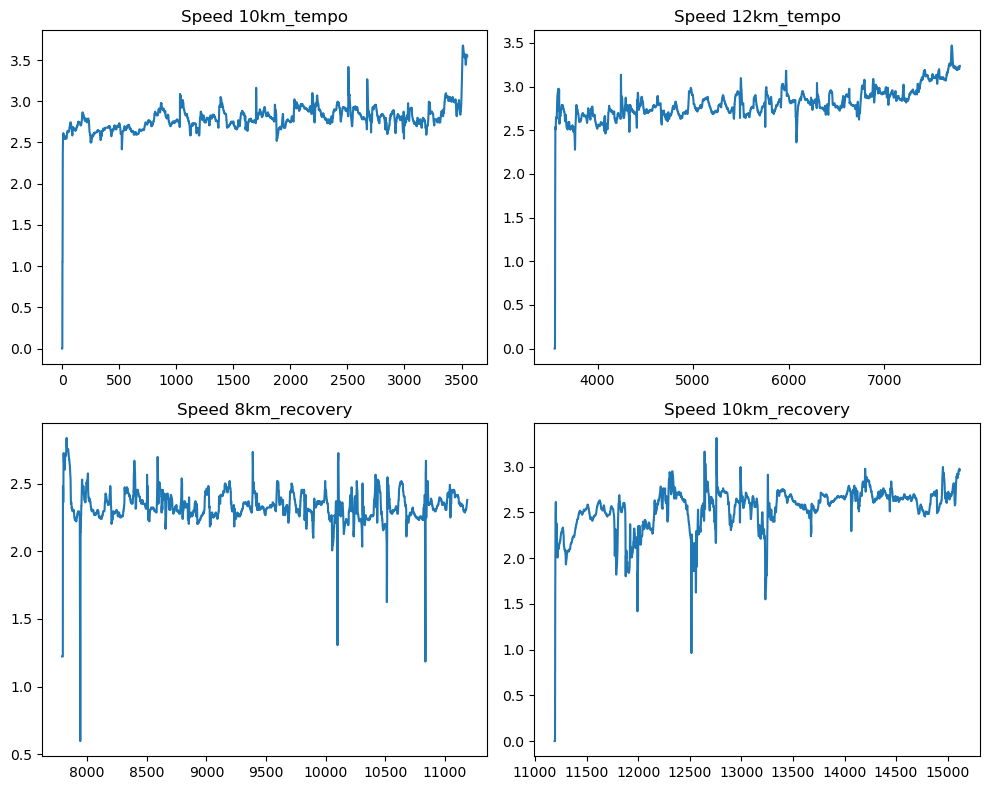

In [97]:
plot_column_per_run(data,'Speed')

### Altitude

In [98]:
data['Altitude'] = data['Altitude'].interpolate(method='polynomial', order=3)
# Forward fill remaining NaNs on a per-run basis
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='ffill')
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='bfill')
#data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='ffill')

In [99]:
#This step can be ommitted in case of bad prediction resutls in ML 
# Choose a window size (number of points to average over)
window_size = 30  # or any other number that seems appropriate for your data

data['Altitude'] = data.groupby('Run')['Altitude'].transform(lambda x: x.rolling(window_size, center=True).mean())
#data['Altitude'] = data['Altitude'].interpolate()
# Forward fill remaining NaNs on a per-run basis
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='ffill')
data['Altitude'] = data.groupby('Run')['Altitude'].fillna(method='bfill')
#data['Altitude'] = data['Altitude'].fillna(method='ffill')
#data['Altitude'] = data['Altitude'].fillna(method='ffill')

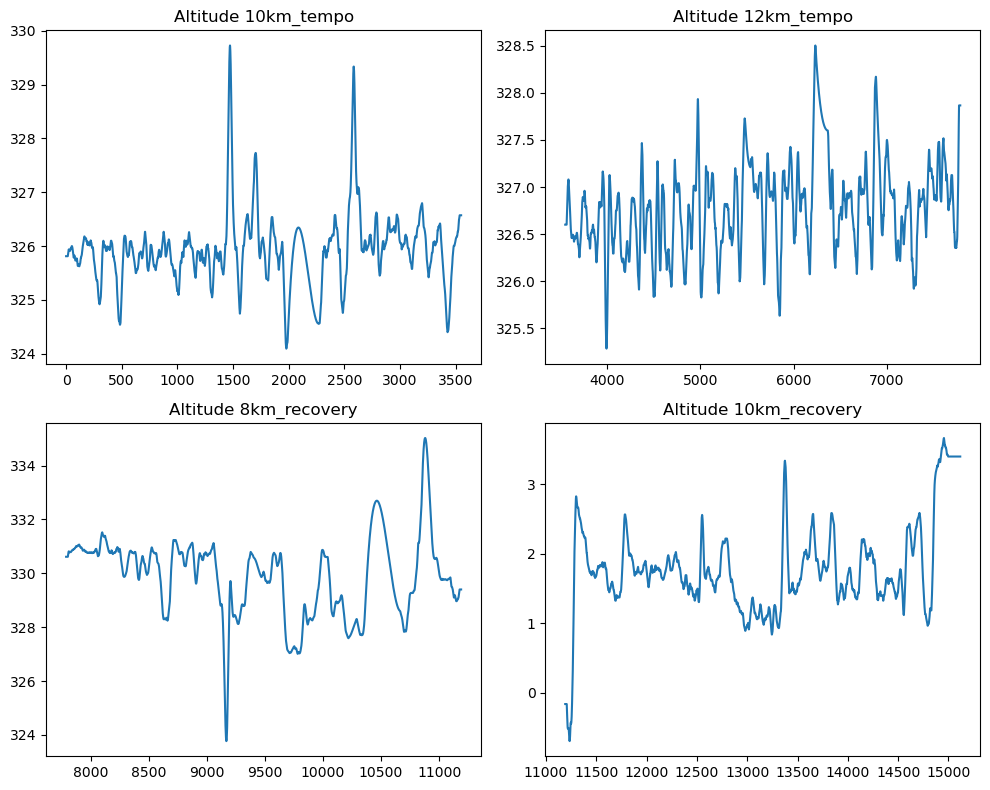

In [100]:
plot_column_per_run(data,'Altitude')

In [101]:
data['Altitude']

0        325.813336
1        325.813336
2        325.813336
3        325.813336
4        325.813336
            ...    
15113      3.400000
15114      3.400000
15115      3.400000
15116      3.400000
15117      3.400000
Name: Altitude, Length: 15118, dtype: float64

In [102]:
count_missing_values(data)

Missing values per column:
Unnamed: 0: 0
Time: 0
Distance: 0
Altitude: 0
HeartRate: 0
Speed: 0
Cadence: 0
HeartRateZone: 0
Run: 0


/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_48719/1562971855.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, count in missing_values.iteritems():


## Exploratory data analysis

/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_48719/1810984961.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


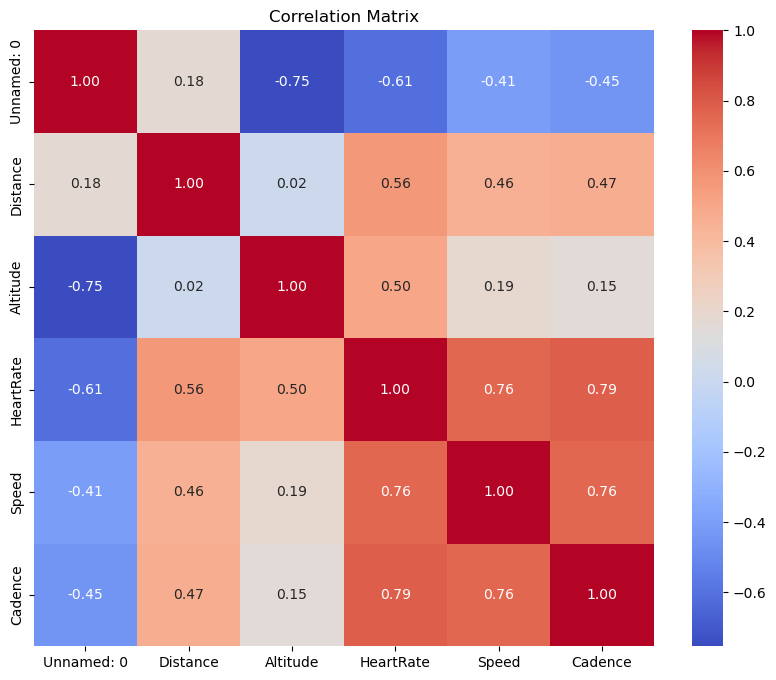

In [103]:
corr_matrix = data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

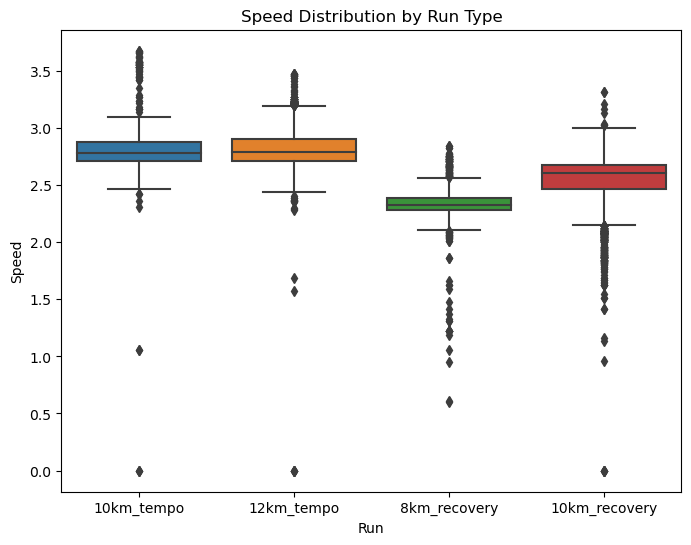

In [104]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Speed', data=data)
plt.title('Speed Distribution by Run Type')
plt.show()

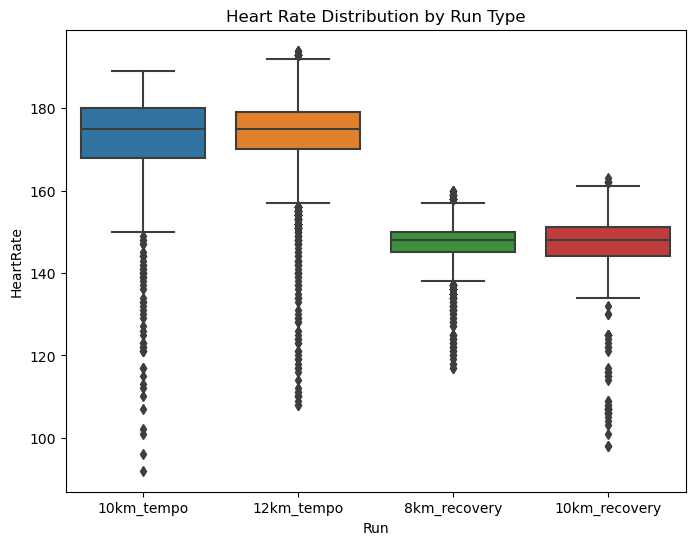

In [105]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='HeartRate', data=data)
plt.title('Heart Rate Distribution by Run Type')
plt.show()

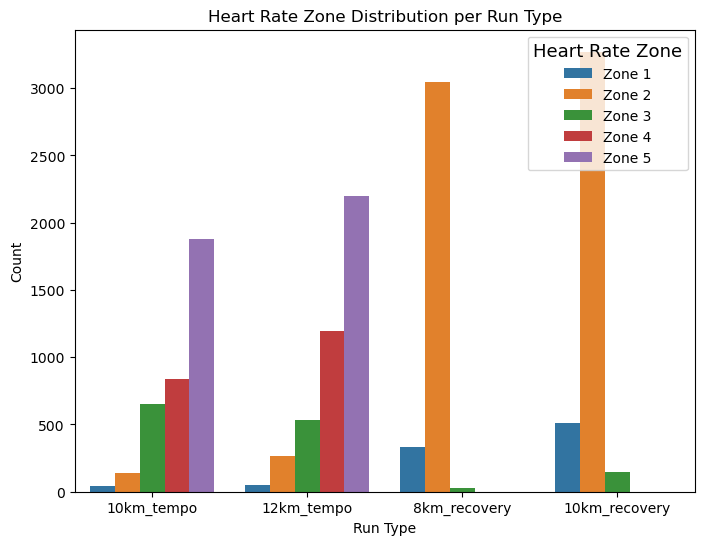

In [106]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Run', hue='HeartRateZone', data=data)
plt.title('Heart Rate Zone Distribution per Run Type')
plt.xlabel('Run Type')
plt.ylabel('Count')
plt.legend(title='Heart Rate Zone', title_fontsize='13', loc='upper right')
plt.show()

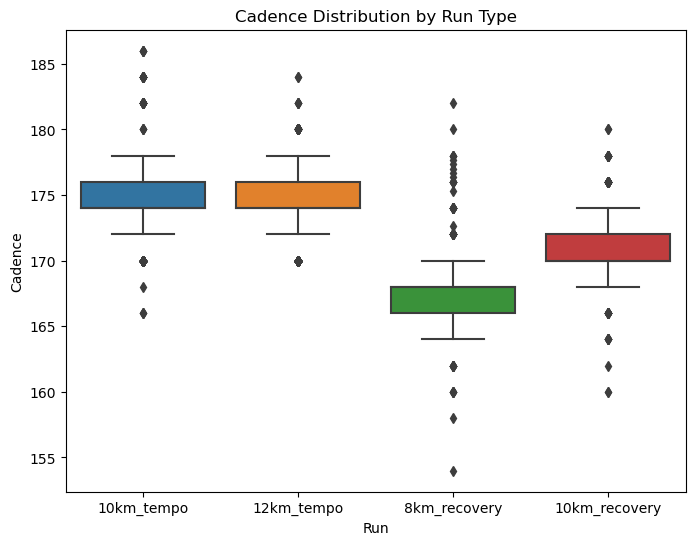

In [107]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Cadence', data=data)
plt.title('Cadence Distribution by Run Type')
plt.show()

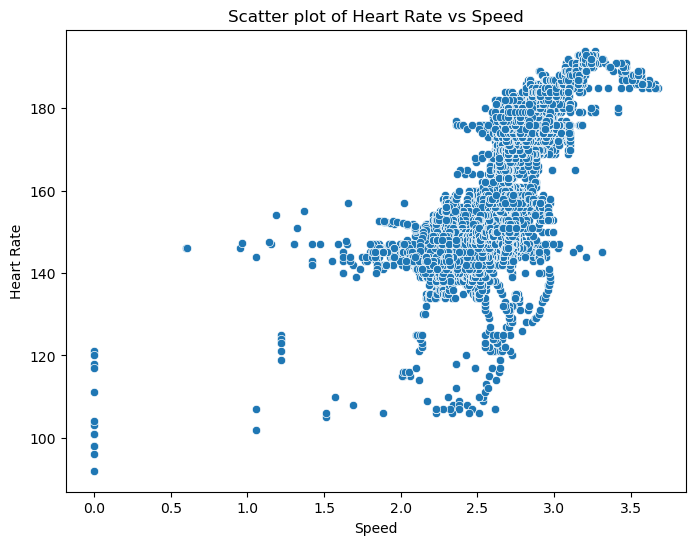

In [108]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Speed', y='HeartRate', data=data)
plt.title('Scatter plot of Heart Rate vs Speed')
plt.xlabel('Speed')
plt.ylabel('Heart Rate')
plt.show()

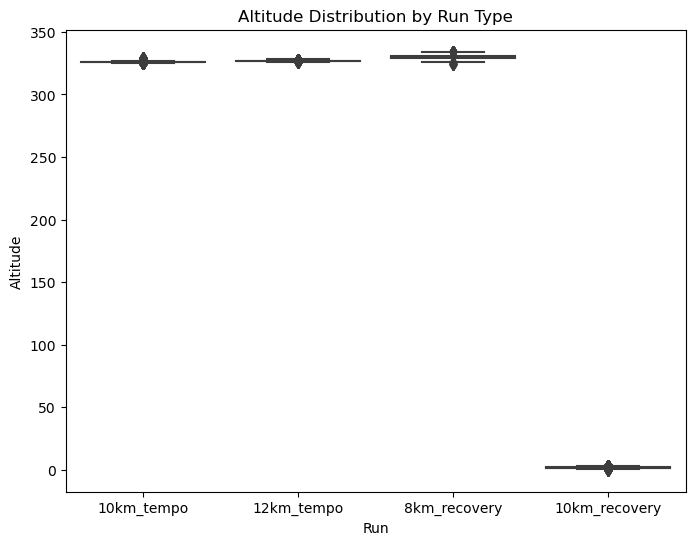

In [109]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Run', y='Altitude', data=data)
plt.title('Altitude Distribution by Run Type')
plt.show()

## Feature Engineering

### Simple features

#### Pace

In [110]:
# compute pace in seconds per meter (s/m)
data['Pace'] = np.where(data['Speed'] != 0, 1 / data['Speed'], 0)
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace
0,0,2022-07-29T05:21:40.000Z,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000
1,1,2022-07-29T05:21:41.000Z,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000
2,2,2022-07-29T05:21:42.000Z,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000
3,3,2022-07-29T05:21:43.000Z,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767
4,4,2022-07-29T05:21:44.000Z,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767
...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06T06:00:59.000Z,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021
15114,15114,2022-09-06T06:00:59.000Z,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021
15115,15115,2022-09-06T06:01:00.000Z,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021
15116,15116,2022-09-06T06:01:01.000Z,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066


#### Acceleration

In [111]:
import datetime

# Convert 'time' from ISO 8601 string format to datetime
data['Time'] = pd.to_datetime(data['Time'])

speed_diff= data['Speed'].diff()
# calculate the difference in time
time_diff = data['Time'].diff().dt.total_seconds()
# compute acceleration in m/s^2
data['Acceleration'] = speed_diff / time_diff
# Fill NaN values in 'acceleration' with zero
data['Acceleration'] = data['Acceleration'].fillna(0)
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000
...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018


#### Steps per run

In [112]:
# Convert cadence from steps per minute to steps per second
data['cadence_per_second'] = data['Cadence'] / 60

# Define a label column for each run, e.g. 'run_label'
#df['run_label'] = ['10km_tempo', '5km_easy', '10km_tempo', ...]
# Calculate total steps per run and convert to DataFrame
total_steps_per_run = data.groupby('Run')['cadence_per_second'].sum().reset_index()
total_steps_per_run.columns = ['Run', 'TotalSteps']

# Merge total steps per run with the original DataFrame
data = pd.merge(data, total_steps_per_run, on='Run', how='left')
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000


#### Run type column 

In [113]:
runtype = data['Run'].str.split('_').str[1]
data['RunType'] = runtype
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps,RunType
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667,tempo
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667,tempo
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667,tempo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000,recovery


#### Elevation gain

In [114]:
#data['Elevation'] = data['Altitude'] / data['Distance']
altitude_diff = data.groupby('Run')['Altitude'].diff()
data['Elevation'] = data.groupby('Run')['Altitude'].diff()
data['Elevation'] = data['Elevation'].fillna(0)
#data.loc[data['Elevation'] < 0, 'Elevation'] = 0
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps,RunType,Elevation
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667,tempo,0.0
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667,tempo,0.0
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667,tempo,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000,recovery,0.0


### One-hot encoding

In [115]:
# one hot encoding for runtype and heart rate zone and run

print(data['RunType'].unique())
print(data['HeartRateZone'].unique())
print(data['Run'].unique())



['tempo' 'recovery']
['Zone 1' 'Zone 2' 'Zone 3' 'Zone 4' 'Zone 5']
['10km_tempo' '12km_tempo' '8km_recovery' '10km_recovery']


In [116]:
# one hot encoding 

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data_onehotencoding = data['RunType']
values = array(data_onehotencoding)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

outcomes_runtype = pd.DataFrame(onehot_encoded, columns=['Recovery', 'Tempo'])
print(outcomes_runtype)

       Recovery  Tempo
0           0.0    1.0
1           0.0    1.0
2           0.0    1.0
3           0.0    1.0
4           0.0    1.0
...         ...    ...
15113       1.0    0.0
15114       1.0    0.0
15115       1.0    0.0
15116       1.0    0.0
15117       1.0    0.0

[15118 rows x 2 columns]


In [90]:
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps,RunType,Elevation
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,tempo,0.0
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667,tempo,0.0
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667,tempo,0.0
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667,tempo,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,recovery,0.0
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000,recovery,0.0


In [118]:
# data_onehotencoding = data['HeartRateZone']
# values = array(data_onehotencoding)

# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)

# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

# outcomes_heartratezone = pd.DataFrame(onehot_encoded, columns=['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5'])
# print(outcomes_heartratezone)

In [119]:
data_onehotencoding = data['Run']
values = array(data_onehotencoding)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])

outcomes_run = pd.DataFrame(onehot_encoded, columns=['10km_recovery','10km_tempo','12km_tempo','8km_recovery'])
print(outcomes_run)

       10km_recovery  10km_tempo  12km_tempo  8km_recovery
0                0.0         1.0         0.0           0.0
1                0.0         1.0         0.0           0.0
2                0.0         1.0         0.0           0.0
3                0.0         1.0         0.0           0.0
4                0.0         1.0         0.0           0.0
...              ...         ...         ...           ...
15113            1.0         0.0         0.0           0.0
15114            1.0         0.0         0.0           0.0
15115            1.0         0.0         0.0           0.0
15116            1.0         0.0         0.0           0.0
15117            1.0         0.0         0.0           0.0

[15118 rows x 4 columns]


/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [120]:
data = pd.merge(data, outcomes_runtype, left_index=True, right_index=True)
# data = pd.merge(data, outcomes_heartratezone, left_index=True, right_index=True)
data = pd.merge(data, outcomes_run, left_index=True, right_index=True)

data



,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,...,cadence_per_second,TotalSteps,RunType,Elevation,Recovery,Tempo,10km_recovery,10km_tempo,12km_tempo,8km_recovery
0,0,2022-07-29 05:21:40+00:00,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,...,2.766667,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,2022-07-29 05:21:41+00:00,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,...,2.766667,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2,2022-07-29 05:21:42+00:00,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,...,2.833333,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,2022-07-29 05:21:43+00:00,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,...,2.833333,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,2022-07-29 05:21:44+00:00,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,...,2.833333,10322.066667,tempo,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,2.866667,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15114,15114,2022-09-06 06:00:59+00:00,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,2.866667,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15115,15115,2022-09-06 06:01:00+00:00,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,...,2.866667,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15116,15116,2022-09-06 06:01:01+00:00,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,...,2.833333,11201.650000,recovery,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [121]:
# subset = data[data['HeartRateZone'] == 'Zone 5']
# subset

## Classification: base features

In [122]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

### Feature selection

In [123]:
# Get counts of each heart rate zone
counts = data['HeartRateZone'].value_counts()

# Print the counts
print(counts)

Zone 2    6720
Zone 5    4081
Zone 4    2035
Zone 3    1357
Zone 1     925
Name: HeartRateZone, dtype: int64


Oopsi, we are dealing with a bit imbalanced dataset 

In [124]:
# Calculate the number of seconds from the start of each run
data['Time'] = data.groupby('Run')['Time'].transform(lambda x: (x - x.min()).dt.total_seconds())

In [125]:
#dropping categorical data that is one-hot encoded
data = data.drop(columns =['RunType'])
data

,Unnamed: 0,Time,Distance,Altitude,HeartRate,Speed,Cadence,HeartRateZone,Run,Pace,Acceleration,cadence_per_second,TotalSteps,Elevation,Recovery,Tempo,10km_recovery,10km_tempo,12km_tempo,8km_recovery
0,0,0.0,1.200000,325.813336,92.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,1.0,3.670000,325.813336,96.0,0.000,166.0,Zone 1,10km_tempo,0.000000,0.000,2.766667,10322.066667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2,2.0,6.070000,325.813336,101.0,0.000,170.0,Zone 1,10km_tempo,0.000000,0.000,2.833333,10322.066667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,3.0,7.870000,325.813336,102.0,1.054,170.0,Zone 1,10km_tempo,0.948767,1.054,2.833333,10322.066667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,4.0,10.080000,325.813336,107.0,1.054,170.0,Zone 1,10km_tempo,0.948767,0.000,2.833333,10322.066667,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,15113,3983.0,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15114,15114,3983.0,10003.740234,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15115,15115,3984.0,10006.309570,3.400000,153.0,2.976,172.0,Zone 2,10km_recovery,0.336021,0.000,2.866667,11201.650000,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15116,15116,3985.0,10010.650391,3.400000,153.0,2.958,170.0,Zone 2,10km_recovery,0.338066,-0.018,2.833333,11201.650000,0.0,1.0,0.0,1.0,0.0,0.0,0.0


/var/folders/l0/924kw60548b_9q6yvy_gzsyc0000gn/T/ipykernel_48719/1810984961.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


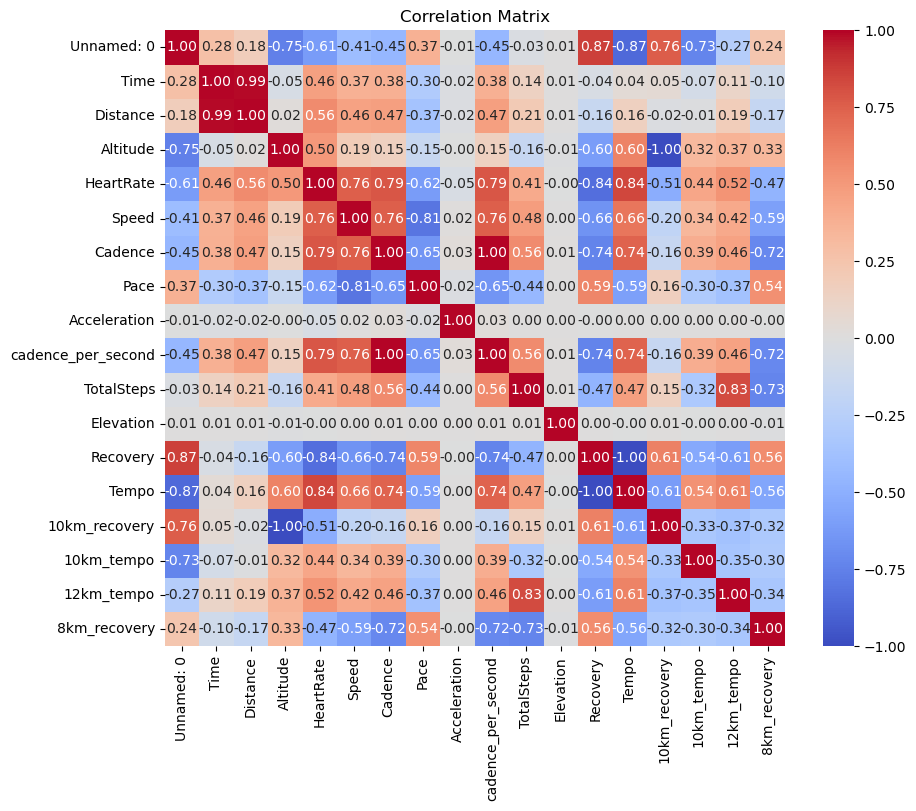

In [126]:
corr_matrix = data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [127]:
data = data.drop(columns= ['Elevation', 'Acceleration', 'Unnamed: 0'])

In [128]:
#Separate features and target
X = data.drop(columns=['HeartRateZone', 'HeartRate', 'Run'])
y = data['HeartRateZone']

from sklearn.preprocessing import LabelEncoder
# Initialize the label encoder
le = LabelEncoder()
# Fit and transform the 'HeartRateZone' column
y = le.fit_transform(y)

# For precicting recovery run
X_train_recovery = X[(X['10km_tempo'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]
y_train_recovery = y[(X['10km_tempo'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]

X_test_recovery = X[X['10km_recovery'] == 1]
y_test_recovery = y[X['10km_recovery'] == 1]

# For precicting  tempo run
X_train_tempo = X[(X['10km_recovery'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]
y_train_tempo = y[(X['10km_recovery'] == 1) | (X['12km_tempo'] == 1) | (X['8km_recovery'] == 1)]

X_test_tempo = X[X['10km_tempo'] == 1]
y_test_tempo = y[X['10km_tempo'] == 1]

# X_train =  X_train.drop(columns=['10km_recovery', '12km_tempo', '8km_recovery', '10km_tempo'])
# X_test  =  X_test.drop(columns=['10km_recovery', '12km_tempo', '8km_recovery','10km_tempo'])


In [129]:
# Normalize features
scaler = StandardScaler()

X_train_recovery = scaler.fit_transform(X_train_recovery)
X_test_recovery  = scaler.transform(X_test_recovery)

X_train_tempo = scaler.fit_transform(X_train_tempo)
X_test_tempo  = scaler.transform(X_test_tempo)

In [130]:
# Train SVM classifier
clf_recovery = svm.SVC()
clf_recovery.fit(X_train_recovery, y_train_recovery)

# Train SVM classifier
clf_tempo = svm.SVC()
clf_tempo.fit(X_train_tempo, y_train_tempo)

SVC()

In [131]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions - recovery
y_pred_recovery = clf_recovery.predict(X_test_recovery)

y_pred = le.inverse_transform(y_pred_recovery)
y_test = le.inverse_transform(y_test_recovery)

# Compute metrics - recovery
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print metrics
print("Recovery run:")
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {confusion}')
print(f'Classification Report:\n {report}')

Recovery run:
Accuracy: 0.12983706720977597
Confusion Matrix:
 [[ 510    0    0]
 [3272    0    0]
 [ 146    0    0]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.13      1.00      0.23       510
      Zone 2       0.00      0.00      0.00      3272
      Zone 3       0.00      0.00      0.00       146

    accuracy                           0.13      3928
   macro avg       0.04      0.33      0.08      3928
weighted avg       0.02      0.13      0.03      3928



/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
# Make predictions - tempo
y_pred_tempo = clf_tempo.predict(X_test_tempo)

y_pred = le.inverse_transform(y_pred_tempo)
y_test = le.inverse_transform(y_test_tempo)

# Compute metrics - recovery
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print metrics
print("Tempo run:")
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {confusion}')
print(f'Classification Report:\n {report}')

Tempo run:
Accuracy: 0.7254294564911292
Confusion Matrix:
 [[  19   20    0    0    0]
 [   0  135    3    0    0]
 [   0  414  214   24    0]
 [  37    0  204  489  110]
 [  31    0    3  129 1719]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.22      0.49      0.30        39
      Zone 2       0.24      0.98      0.38       138
      Zone 3       0.50      0.33      0.40       652
      Zone 4       0.76      0.58      0.66       840
      Zone 5       0.94      0.91      0.93      1882

    accuracy                           0.73      3551
   macro avg       0.53      0.66      0.53      3551
weighted avg       0.78      0.73      0.74      3551



### Resampling

In [133]:
from imblearn.over_sampling import ADASYN

# Define ADASYN
ada = ADASYN(random_state=42)

# Fit ADASYN to the training data
X_train_res_recovery, y_train_res_recovery = ada.fit_resample(X_train_recovery, y_train_recovery)
X_train_res_tempo, y_train_res_tempo = ada.fit_resample(X_train_tempo, y_train_tempo)

clf_recovery = svm.SVC()
clf_recovery.fit(X_train_res_recovery, y_train_res_recovery)

clf_tempo = svm.SVC()
clf_tempo.fit(X_train_res_tempo, y_train_res_tempo)

# Make predictions - recovery
y_pred_recovery = clf_recovery.predict(X_test_recovery)
y_pred_tempo = clf_recovery.predict(X_test_tempo)

y_pred = le.inverse_transform(y_pred_recovery)
y_test = le.inverse_transform(y_test_recovery)

# Compute metrics - recovery
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print metrics
print("Recovery: ")
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {confusion}')
print(f'Classification Report:\n {report}')

y_pred = le.inverse_transform(y_pred_tempo)
y_test = le.inverse_transform(y_test_tempo)

# Compute metrics - recovery
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print metrics
print("Tempo: ")
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {confusion}')
print(f'Classification Report:\n {report}')



Recovery: 
Accuracy: 0.8329938900203666
Confusion Matrix:
 [[   0  510    0]
 [   0 3272    0]
 [   0  146    0]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.00      0.00      0.00       510
      Zone 2       0.83      1.00      0.91      3272
      Zone 3       0.00      0.00      0.00       146

    accuracy                           0.83      3928
   macro avg       0.28      0.33      0.30      3928
weighted avg       0.69      0.83      0.76      3928

Tempo: 
Accuracy: 0.7051534778935511
Confusion Matrix:
 [[  39    0    0    0    0]
 [  91    0   47    0    0]
 [  43    0  558   24   27]
 [   0    0  236   28  576]
 [   0    0    3    0 1879]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.23      1.00      0.37        39
      Zone 2       0.00      0.00      0.00       138
      Zone 3       0.66      0.86      0.75       652
      Zone 4       0.54      0.03      0.06

/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nastiamazurak/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Use

#### SVM Parameter tuning

In [134]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter values to be searched
# param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#               'kernel': ['linear', 'rbf']} 

# # Initialize the SVM classifier
# clf = svm.SVC()

# # Perform grid search
# grid_recovery = GridSearchCV(clf, param_grid, refit = True, verbose = 3)
# grid_tempo = GridSearchCV(clf, param_grid, refit = True, verbose = 3)

# # Fit the grid search object
# grid_recovery.fit(X_train_recovery, y_train_recovery)
# grid_tempo.fit(X_train_tempo, y_train_tempo)

# # Print the best parameters and estimator
# print("Recovery: ")
# print(f"Best parameters: {grid_recovery.best_params_}")
# print(f"Best estimator: {grid_recovery.best_estimator_}")

# print("Tempo: ")
# print(f"Best parameters: {grid_tempo.best_params_}")
# print(f"Best estimator: {grid_tempo.best_estimator_}")

#### Summary

**Including all features** : 0.65 (for tempo run)

**After dropping low correlation features**:
- Accuracy 10km recovery run:  0.129
- Accuracy 10km tempo run: 0.7254 

Why: Because model strugling predicting Zone 1, Zone 2 and Zone 3.

**After resampling:**
- Accuracy 10km recovery run: 0.8329
- Accuracy 10km tempo run: 0.7051

**After parameter tuning:**
- Accuracy 10km recovery run:  ???
- Accuracy 10km tempo run: ???

### Generalized data spliting per each run (70% - training, 30% - test per run)

In [135]:
def split_data(data, test_size=0.3):
    runs = data['Run'].unique()
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for run in runs:
        run_data = data[data['Run'] == run]
        train_run = run_data.sample(frac=1-test_size, random_state=42)
        test_run = run_data.drop(train_run.index)
        
        train_data = pd.concat([train_data, train_run])
        test_data = pd.concat([test_data, test_run])
        
    return train_data, test_data

# Use the function to split your data
train_data, test_data = split_data(data)

# Now you can separate the features and the target variable
X_train = train_data.drop(['HeartRateZone','HeartRate', 'Run'], axis=1)
y_train = train_data['HeartRateZone']
X_test = test_data.drop(['HeartRateZone', 'HeartRate','Run'], axis=1)
y_test = test_data['HeartRateZone']

# Fit and transform the 'HeartRateZone' column
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [136]:
clf= svm.SVC()
clf.fit(X_train, y_train)

# Make predictions - recovery
y_pred = clf.predict(X_test)

y_pred = le.inverse_transform(y_pred)
y_test = le.inverse_transform(y_test)

# Compute metrics - recovery
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {confusion}')
print(f'Classification Report:\n {report}')

Accuracy: 0.8853109836788707
Confusion Matrix:
 [[ 154  120    0    0    0]
 [  25 1940   65    0    0]
 [   0   62  303   33    0]
 [   0    0   14  484   94]
 [   0    0    0  107 1133]]
Classification Report:
               precision    recall  f1-score   support

      Zone 1       0.86      0.56      0.68       274
      Zone 2       0.91      0.96      0.93      2030
      Zone 3       0.79      0.76      0.78       398
      Zone 4       0.78      0.82      0.80       592
      Zone 5       0.92      0.91      0.92      1240

    accuracy                           0.89      4534
   macro avg       0.85      0.80      0.82      4534
weighted avg       0.88      0.89      0.88      4534



### Randomly splitting the dataset

In [144]:
from sklearn.model_selection import train_test_split
# Split your data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Fit and transform the 'HeartRateZone' column
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.fit_transform(y_test)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [145]:
clf= svm.SVC()
clf.fit(X_train, y_train)

# Make predictions - recovery
y_pred = clf.predict(X_test)

# Compute metrics - recovery
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n {confusion}')
print(f'Classification Report:\n {report}')

Accuracy: 0.8862433862433863
Confusion Matrix:
 [[ 134  126    0    0    0]
 [  31 1950   76    0    0]
 [   1   75  314   31    0]
 [   0    0   11  491   80]
 [   0    0    0   85 1131]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.52      0.63       260
           1       0.91      0.95      0.93      2057
           2       0.78      0.75      0.76       421
           3       0.81      0.84      0.83       582
           4       0.93      0.93      0.93      1216

    accuracy                           0.89      4536
   macro avg       0.85      0.80      0.82      4536
weighted avg       0.88      0.89      0.88      4536

